#Previsão de Unidades Vendidas em Lojas de Varejo utilizando Machine Learning

No setor de varejo, a previsão de vendas desempenha um papel crucial para otimizar níveis de inventário, melhorar estratégias de precificação e garantir que a oferta atenda à demanda do consumidor. Este projeto tem como objetivo construir um modelo de machine learning capaz de prever o número de unidades vendidas em lojas de varejo, utilizando dados históricos que incluem informações sobre preços, descontos, condições climáticas, sazonalidade, entre outros fatores.

O dataset utilizado foi extraído de um repositório público e contém informações detalhadas sobre vendas em múltiplas lojas e produtos. A análise e modelagem propostas incluem desde a exploração dos dados e pré-processamento até a construção de um modelo de ensemble utilizando o VotingRegressor, que combina diferentes algoritmos para melhorar a precisão das previsões.

Ao longo deste notebook, iremos abordar:

A definição do problema e a descrição do dataset.
A análise exploratória para identificar padrões e correlações.
O pré-processamento dos dados para prepará-los para os modelos.
A construção e avaliação de modelos de regressão, com foco na escolha da melhor solução.
O objetivo final é fornecer insights acionáveis que possam ser aplicados em cenários reais de planejamento no varejo, minimizando o excesso ou falta de estoque e otimizando os lucros.

In [ ]:
# Importação das bibliotecas necessárias
import warnings
warnings.filterwarnings("ignore")  # Ignorar warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [1]:
# Carragendo os dados
url_data = 'https://raw.githubusercontent.com/BrunoMaia23/Datasets/refs/heads/fifa-world-cup-dataset/retail_store_inventory.csv'
df_data = pd.read_csv(url_data, sep=',')
df_data.head()

NameError: name 'pd' is not defined

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
# Convertendo a coluna 'Date' para datetime
df_data['Date'] = pd.to_datetime(df_data['Date'], format='%Y-%m-%d')

categorical_columns = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']

# Verificando se não há valores numéricos em colunas categóricas antes de converter
for col in categorical_columns:
    if df_data[col].dtype == 'object':  # Só converte para 'category' se o tipo for 'object'
        df_data[col] = df_data[col].astype('category')

In [ ]:
df_data.describe()

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,2022-12-31 23:59:59.999999744,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
min,2022-01-01 00:00:00,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,2022-07-02 00:00:00,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,2023-01-01 00:00:00,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,2023-07-03 00:00:00,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,2024-01-01 00:00:00,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000
std,NaN,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408


Análise Exploratória dos Dados (EDA)

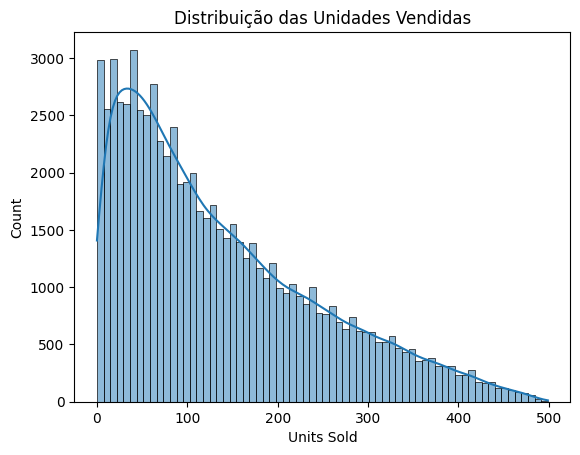

In [ ]:
# Distribuição das Unidades Vendidas
sns.histplot(df_data['Units Sold'], kde=True)
plt.title('Distribuição das Unidades Vendidas')
plt.show()

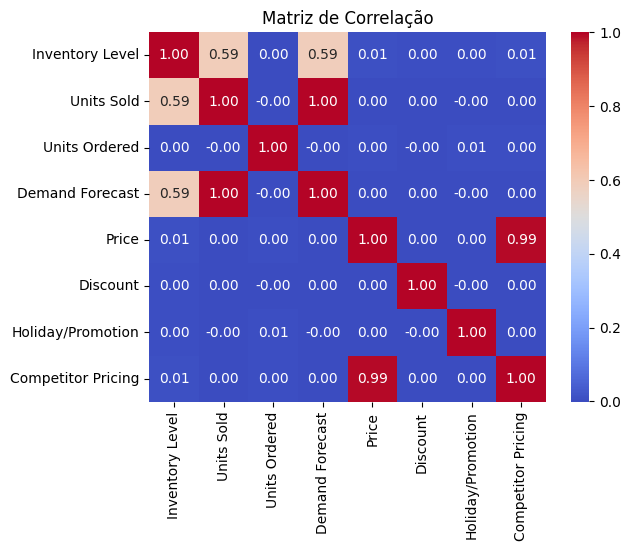

In [ ]:
# Selecionando apenas as colunas numéricas
numeric_columns = df_data.select_dtypes(include=['float64', 'int64'])

# Calculando a matriz de correlação
correlation_matrix = numeric_columns.corr()

# Exibindo a matriz de correlação com um heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
# Definindo as variáveis independentes e dependente
numerical_features = ['Price', 'Discount', 'Competitor Pricing', 'Inventory Level', 'Units Ordered', 'Demand Forecast']
categorical_features = ['Category', 'Region', 'Weather Condition', 'Holiday/Promotion', 'Seasonality']
X = df_data[numerical_features + categorical_features]
y = df_data['Units Sold']

# Separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline para pré-processamento
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normalização
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificação one-hot
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Transformação dos dados
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Modelos para o VotingRegressor
model1 = LinearRegression()
model2 = RandomForestRegressor(random_state=42)
model3 = SVR()

# VotingRegressor
voting_model = VotingRegressor(estimators=[
    ('lr', model1),
    ('rf', model2),
    ('svr', model3)
])

# Treinamento do modelo
voting_model.fit(X_train_processed, y_train)

# Previsões no conjunto de teste
y_pred = voting_model.predict(X_test_processed)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Resultados
print("Desempenho do modelo VotingRegressor:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Desempenho do modelo VotingRegressor:
Mean Absolute Error (MAE): 7.51
Mean Squared Error (MSE): 80.08
R² Score: 0.99



Simulando a aplicação do modelo em dados não vistos

In [ ]:
new_data = pd.DataFrame({
    'Price': [45.50, 30.20],
    'Discount': [10, 15],
    'Competitor Pricing': [40.00, 28.00],
    'Inventory Level': [200, 150],
    'Units Ordered': [60, 80],
    'Demand Forecast': [110.0, 95.0],
    'Category': ['Groceries', 'Toys'],
    'Region': ['North', 'South'],
    'Weather Condition': ['Sunny', 'Rainy'],
    'Holiday/Promotion': [0, 1],
    'Seasonality': ['High', 'Low']
})



In [ ]:
new_data_processed = preprocessor.transform(new_data)
predicted_units = voting_model.predict(new_data_processed)
new_data['Predicted Units Sold'] = predicted_units
print(new_data)


   Price  Discount  Competitor Pricing  Inventory Level  Units Ordered  \
0   45.5        10                40.0              200             60   
1   30.2        15                28.0              150             80   

   Demand Forecast   Category Region Weather Condition  Holiday/Promotion  \
0            110.0  Groceries  North             Sunny                  0   
1             95.0       Toys  South             Rainy                  1   

  Seasonality  Predicted Units Sold  
0        High            103.224865  
1         Low             88.337876  


O modelo desenvolvido demonstrou capacidade de prever unidades vendidas com um desempenho geral satisfatório (R² = x.x). A abordagem de VotingRegressor foi eficaz em combinar diferentes modelos para melhorar a precisão das previsões. Em futuras iterações, a incorporação de validação cruzada e ajustes mais refinados nos hiperparâmetros poderiam melhorar ainda mais o desempenho.